In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # for plotting
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,  ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

# grid search
from sklearn.model_selection import RandomizedSearchCV

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score


#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('survey.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [4]:
df = df.drop(['comments'], axis= 1)
df = df.drop(['state'], axis= 1)
df = df.drop(['Timestamp'], axis= 1)

In [5]:
df.head()

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [6]:
df.isna().sum()

Age                            0
Gender                         0
Country                        0
self_employed                 18
family_history                 0
treatment                      0
work_interfere               264
no_employees                   0
remote_work                    0
tech_company                   0
benefits                       0
care_options                   0
wellness_program               0
seek_help                      0
anonymity                      0
leave                          0
mental_health_consequence      0
phys_health_consequence        0
coworkers                      0
supervisor                     0
mental_health_interview        0
phys_health_interview          0
mental_vs_physical             0
obs_consequence                0
dtype: int64

In [7]:
# Assign default values for each data type
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

for feature in df:
    if feature in intFeatures:
        df[feature] = df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        df[feature] = df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        df[feature] = df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)

In [8]:
df['Gender'].unique()

array(['Female', 'M', 'Male', 'male', 'female', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they',
       'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'All', 'Enby',
       'fluid', 'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous',
       'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)',
       'queer', 'Female (cis)', 'Mail', 'cis male', 'A little about you',
       'Malr', 'p', 'femail', 'Cis Man',
       'ostensibly male, unsure what that really means'], dtype=object)

In [9]:
gender = df['Gender'].str.lower() #lower case all column's elements

gender = df['Gender'].unique() #Select unique elements

# Making gender groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in df.iterrows():

    if str.lower(col.Gender) in male_str:
        df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

# Removing invalid values
stk_list = ['A little about you', 'p']
df = df[~df['Gender'].isin(stk_list)]

df['Gender'].unique()

array(['female', 'male', 'trans'], dtype=object)

In [10]:
# Replace missing age values with the median
df['Age'] = df['Age'].fillna(df['Age'].median())

# Ensure we are modifying the original DataFrame properly
df.loc[df['Age'] < 18, 'Age'] = df['Age'].median()
df.loc[df['Age'] > 120, 'Age'] = df['Age'].median()

# Define Age Ranges
df['age_range'] = pd.cut(
    df['Age'], bins=[0, 20, 30, 65, 100],
    labels=["0-20", "21-30", "31-65", "66-100"],
    include_lowest=True
)

In [11]:
df['age_range'].value_counts()

age_range
31-65     677
21-30     557
0-20       22
66-100      1
Name: count, dtype: int64

In [12]:
df['self_employed'].unique()

array(['NaN', 'Yes', 'No'], dtype=object)

In [13]:
#There are almost negilgable amount of entries of self employed so let's change NaN to NOT self_employed
#Replace "NaN" string from defaultString
df['self_employed'] = df['self_employed'].replace([defaultString], 'No')
df['self_employed'].unique()

array(['No', 'Yes'], dtype=object)

In [14]:
df['work_interfere'].value_counts()

work_interfere
Sometimes    465
NaN          264
Never        213
Rarely       173
Often        142
Name: count, dtype: int64

In [15]:
#Replace "NaN" string from defaultString

df['work_interfere'] = df['work_interfere'].replace([defaultString], 'Don\'t know' )
df['work_interfere'].unique()

array(['Often', 'Rarely', 'Never', 'Sometimes', "Don't know"],
      dtype=object)

In [16]:
df.columns

Index(['Age', 'Gender', 'Country', 'self_employed', 'family_history',
       'treatment', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'age_range'],
      dtype='object')

In [17]:
labelDictionary = {}
for feature in df:
    le = preprocessing.LabelEncoder()
    le.fit(df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    df[feature] = le.transform(df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDictionary[labelKey] =labelValue

for key, value in labelDictionary.items():
    print(key, value)

df = df.drop(['Country'], axis= 1)
df.head()

label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_emp

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


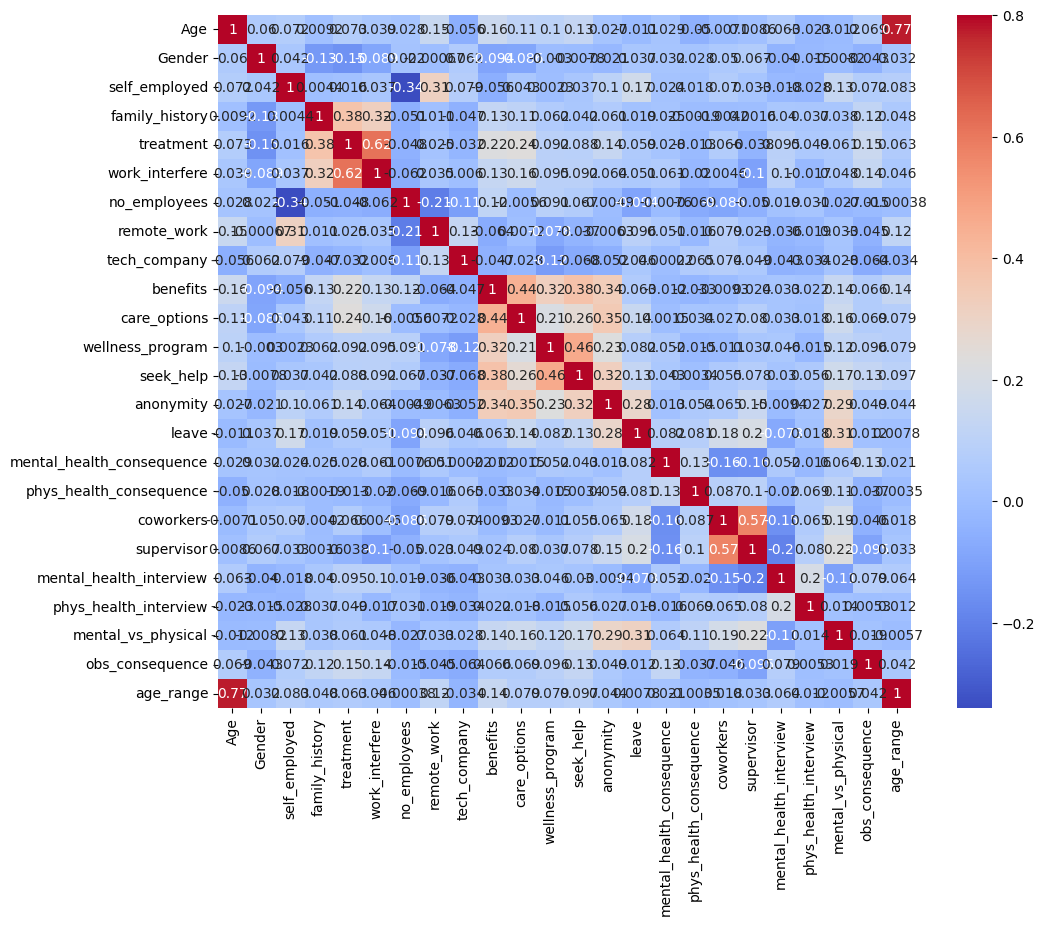

In [18]:
# Compute the correlation matrix
corrmat = df.corr()

# Correct the argument name (use figsize instead of figheight)
f, ax = plt.subplots(figsize=(12, 9))

# Create a heatmap
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, cmap="coolwarm")

# Display the plot
plt.show()

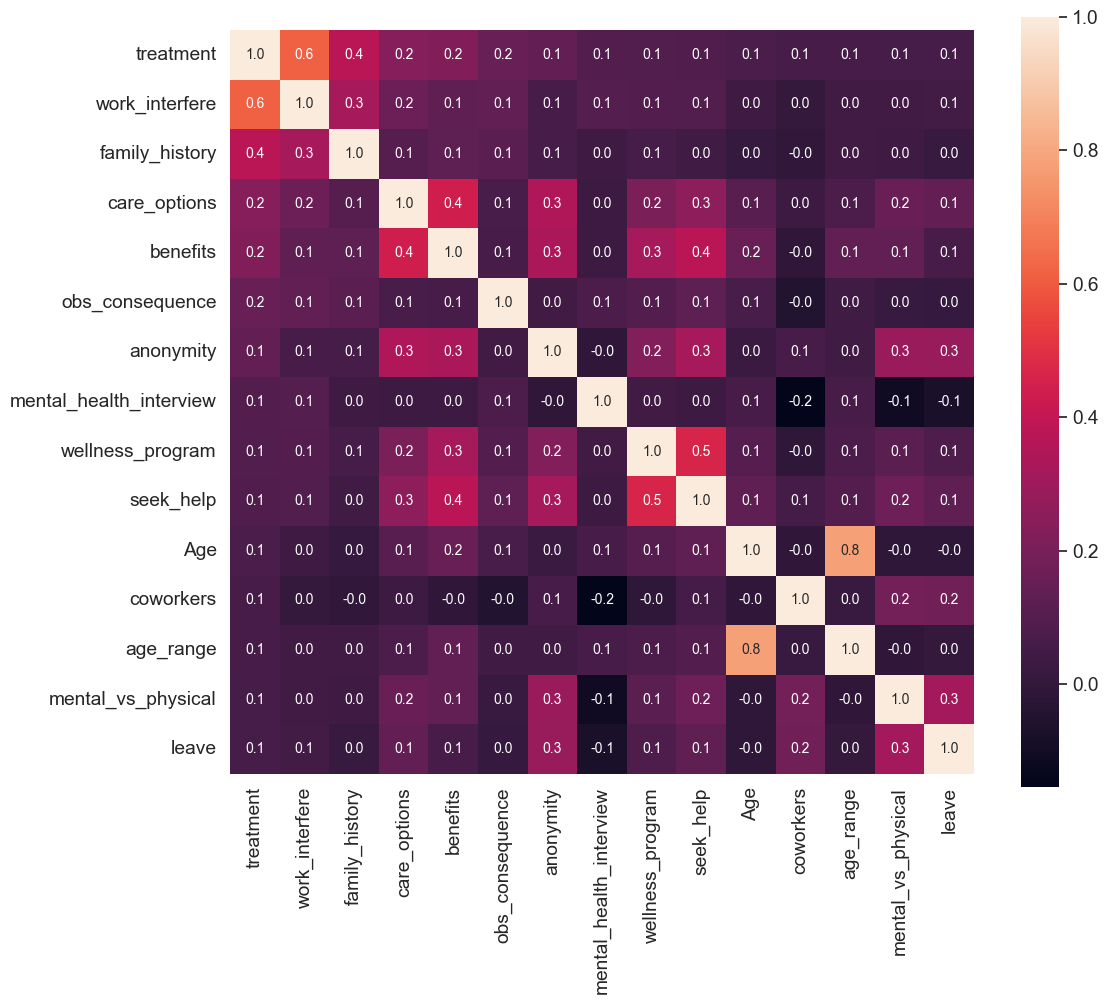

In [19]:
#treatment correlation matrix
plt.figure(figsize=(12,10))
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.1f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

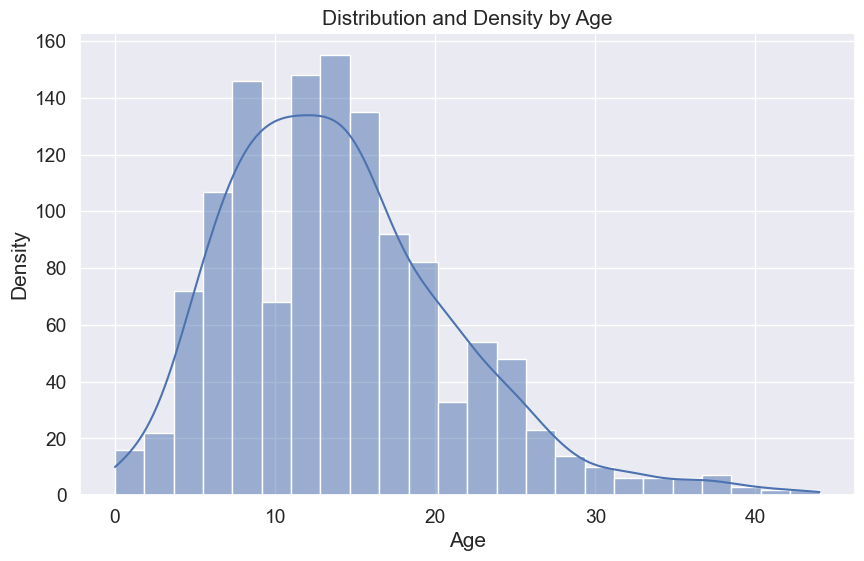

In [20]:
plt.figure(figsize=(10, 6))

# Use sns.histplot instead of sns.distplot (since distplot is deprecated)
sns.histplot(df["Age"], bins=24, kde=True)

# Add titles and labels
plt.title("Distribution and Density by Age")
plt.xlabel("Age")
plt.ylabel("Density")

# Show the plot
plt.show()

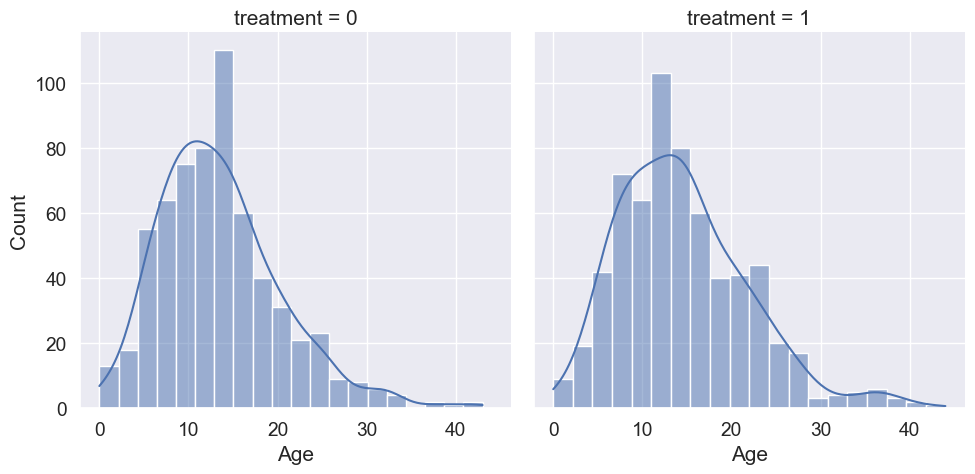

In [21]:
# Separate by treatment or not
g = sns.FacetGrid(df, col='treatment', height=5)

# Use sns.histplot() instead of sns.distplot()
g.map(sns.histplot, "Age", bins=20, kde=True)

plt.show()

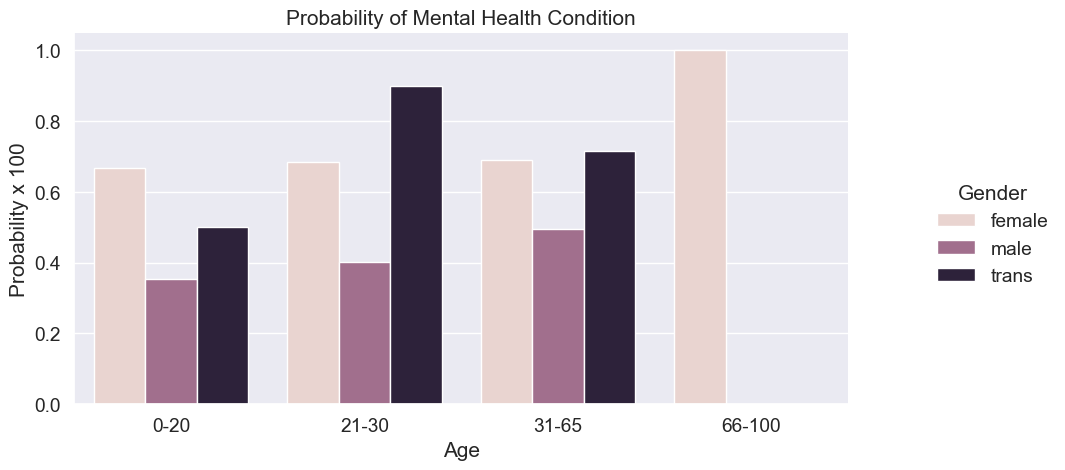

In [22]:
label_age = labelDictionary['label_age_range']

# Use errorbar=None instead of ci=None
g = sns.catplot(
    x="age_range", y="treatment", hue="Gender",
    data=df, kind="bar",
    errorbar=None, height=5, aspect=2, legend_out=True
)

# Set custom tick labels
g.set_xticklabels(label_age)

# Set plot title and labels
plt.title('Probability of Mental Health Condition')
plt.ylabel('Probability x 100')
plt.xlabel('Age')

# Replace legend labels
new_labels = labelDictionary['label_Gender']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# Adjust legend position
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()

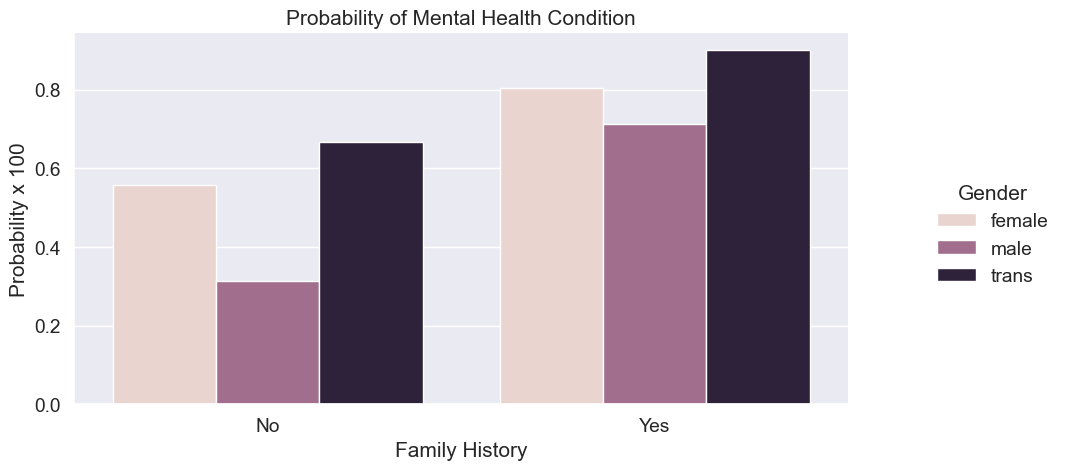

In [23]:
o = labelDictionary['label_family_history']

# Use errorbar=None instead of ci=None
g = sns.catplot(
    x="family_history", y="treatment", hue="Gender",
    data=df, kind="bar",
    errorbar=None, height=5, aspect=2, legend_out=True
)

# Set custom tick labels
g.set_xticklabels(o)

# Set plot title and labels
plt.title('Probability of Mental Health Condition')
plt.ylabel('Probability x 100')
plt.xlabel('Family History')

# Replace legend labels
new_labels = labelDictionary['label_Gender']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# Adjust legend position
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()

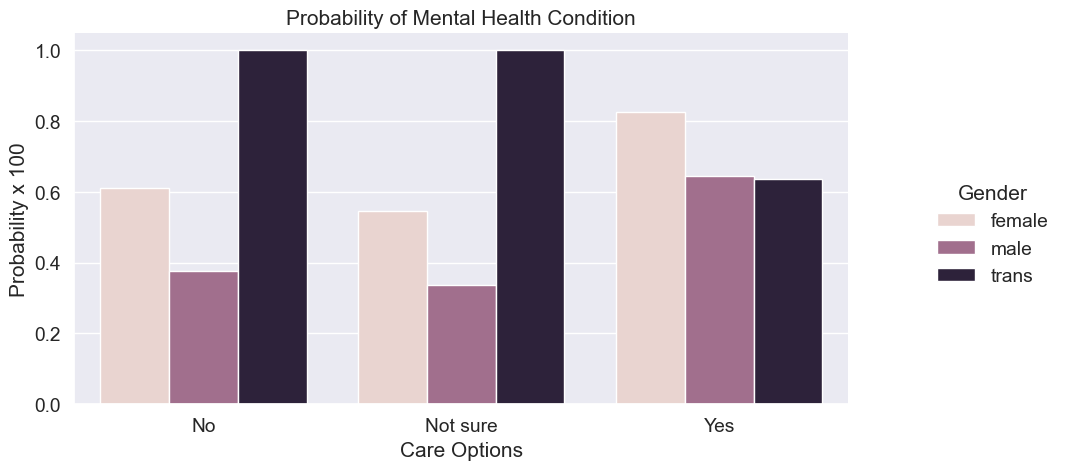

In [24]:
o = labelDictionary['label_care_options']

# Use errorbar=None instead of ci=None
g = sns.catplot(
    x="care_options", y="treatment", hue="Gender",
    data=df, kind="bar",
    errorbar=None, height=5, aspect=2, legend_out=True
)

# Set custom tick labels
g.set_xticklabels(o)

# Set plot title and labels
plt.title('Probability of Mental Health Condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care Options')

# Replace legend labels
new_labels = labelDictionary['label_Gender']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# Adjust legend position
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()

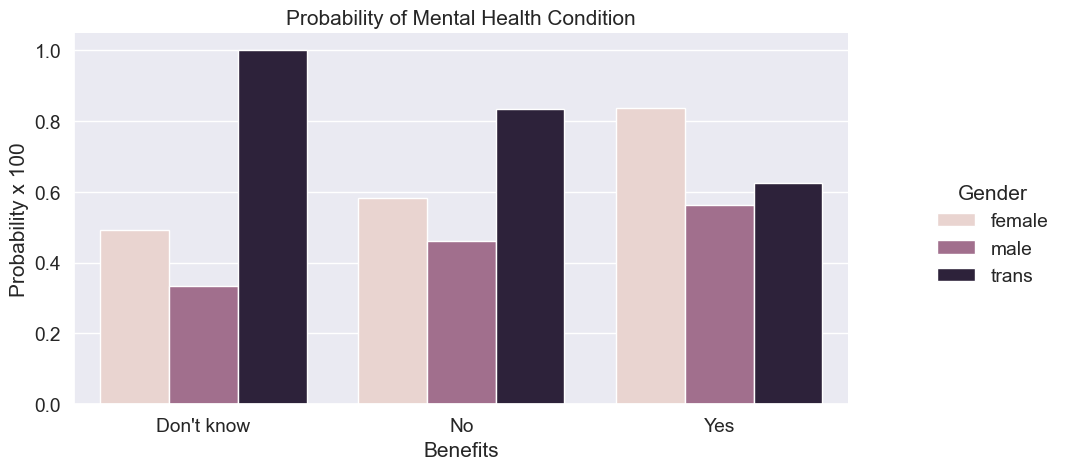

In [25]:
o = labelDictionary['label_benefits']

# Use errorbar=None instead of ci=None
g = sns.catplot(
    x="benefits", y="treatment", hue="Gender",  # Ensure x="benefits" is correct
    data=df, kind="bar",
    errorbar=None, height=5, aspect=2, legend_out=True
)

# Set custom tick labels
g.set_xticklabels(o)

# Set plot title and labels
plt.title('Probability of Mental Health Condition')
plt.ylabel('Probability x 100')
plt.xlabel('Benefits')

# Replace legend labels
new_labels = labelDictionary['label_Gender']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# Adjust legend position
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()


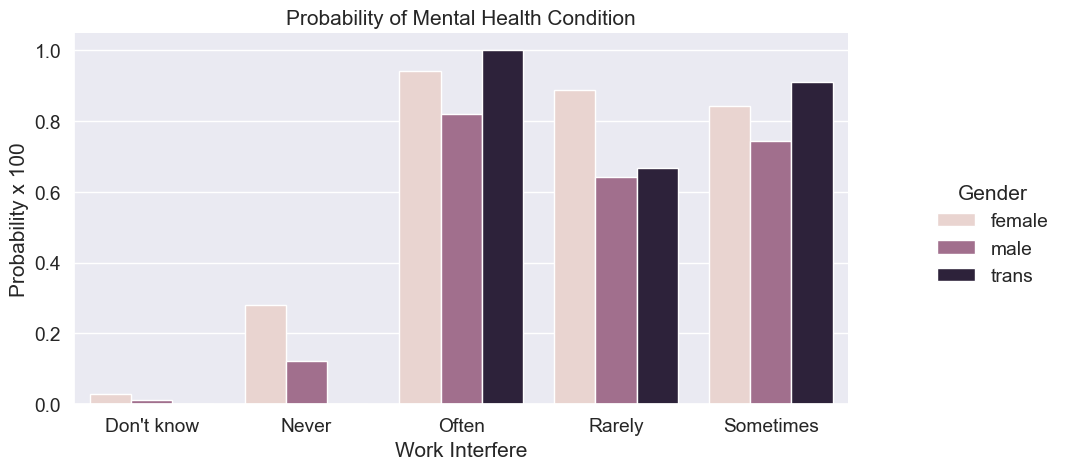

In [26]:
o = labelDictionary['label_work_interfere']

# Use errorbar=None instead of ci=None
g = sns.catplot(
    x="work_interfere", y="treatment", hue="Gender",
    data=df, kind="bar",
    errorbar=None, height=5, aspect=2, legend_out=True
)

# Set custom tick labels
g.set_xticklabels(o)

# Set plot title and labels
plt.title('Probability of Mental Health Condition')
plt.ylabel('Probability x 100')
plt.xlabel('Work Interfere')

# Replace legend labels
new_labels = labelDictionary['label_Gender']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# Adjust legend position
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()


In [27]:
#Features Scaling We're going to scale age, because is extremely different from the other ones.
# Scaling Age
scaler = MinMaxScaler()
df['Age'] = scaler.fit_transform(df[['Age']])
df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


In [28]:
# Define feature columns and target variable
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = df[feature_cols]
y = df['treatment']  # Ensure y is correctly selected

# Split X and y into training and testing sets (corrected parameter name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Create dictionaries for final graph
methodDictionary = {}

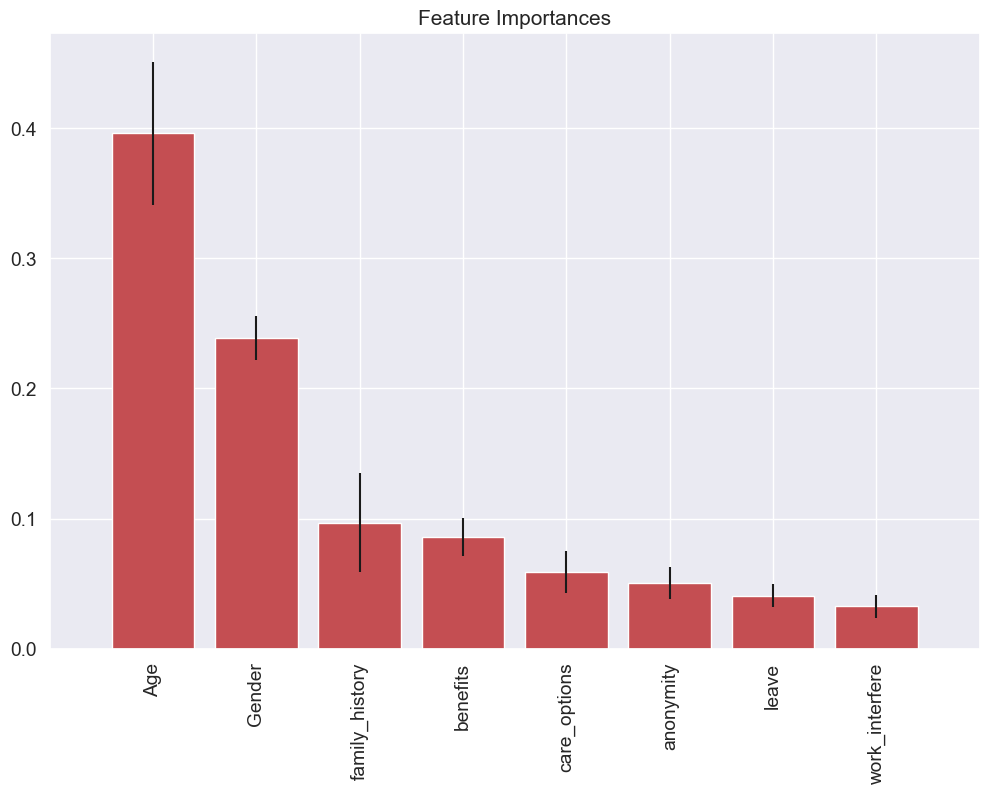

In [29]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

labels = [feature_cols[f] for f in range(X.shape[1])]

# Plot the feature importances of the forest
plt.figure(figsize=(12, 8))

plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])

plt.show()

In [30]:
def evalClassModel(model, y_test, y_pred_class, plot=False):

    #Classification accuracy: percentage of correct predictions
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))  # calculate accuracy

    #Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    print('Null accuracy:\n', y_test.value_counts()) # examine the class distribution of the testing set (using a Pandas Series method)

    print('Percentage of ones:', y_test.mean()) # calculate the percentage of ones

    # calculate the percentage of zeros
    print('Percentage of zeros:',1 - y_test.mean()) # calculate the percentage of zeros

    #Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])


    #Confusion matrix
    # save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    #Metrics computed from a confusion matrix

    #Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)

    #Classification Error: Overall, how often is the classifier incorrect?
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))

    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)

    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))


    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))

    # calculate cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())

    "----------------------------------------"
    #Adjusting the classification threshold
    "----------------------------------------"
    # print the first 10 predicted responses
    # 1D array (vector) of binary values (0, 1)
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])


    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10]) # print the first 10 predicted probabilities of class membership


    model.predict_proba(X_test)[0:10, 1] # print the first 10 predicted probabilities for class 1


    y_pred_prob = model.predict_proba(X_test)[:, 1] # store the predicted probabilities for class 1

    if plot == True:
        # histogram of predicted probabilities

        plt.rcParams['font.size'] = 12 # adjust the font size

        plt.hist(y_pred_prob, bins=8) # 8 bins


        plt.xlim(0,1) # x-axis limit from 0 to 1
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')


    # predict treatment if the predicted probability is greater than 0.3
    # it will return 1 for all values above 0.3 and 0 otherwise
    # results are 2D so we slice out the first column
    y_pred_prob = y_pred_prob.reshape(-1,1)
    y_pred_class = binarize(y_pred_prob, threshold=0.3)

    # print the first 10 predicted probabilities
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])

    # One way of setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)


    return accuracy

----------- Logistic Regression -------------
Accuracy: 0.7896825396825397
Null accuracy:
 treatment
0    129
1    123
Name: count, dtype: int64
Percentage of ones: 0.4880952380952381
Percentage of zeros: 0.5119047619047619
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


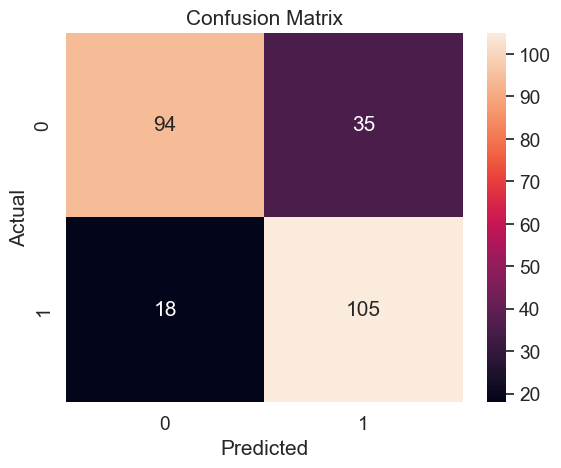

Classification Accuracy: 0.7896825396825397
Classification Error: 0.21031746031746035
False Positive Rate: 0.2713178294573643
Precision: 0.75
AUC Score: 0.7911703535640007
Cross-validated AUC: 0.8753371866593114
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 0 1]
First 10 predicted probabilities of class members:
 [[0.08627888 0.91372112]
 [0.96087085 0.03912915]
 [0.96734979 0.03265021]
 [0.79977748 0.20022252]
 [0.43398357 0.56601643]
 [0.0523193  0.9476807 ]
 [0.75463716 0.24536284]
 [0.21360542 0.78639458]
 [0.58869772 0.41130228]
 [0.45888139 0.54111861]]
First 10 predicted probabilities:
 [[0.91372112]
 [0.03912915]
 [0.03265021]
 [0.20022252]
 [0.56601643]
 [0.9476807 ]
 [0.24536284]
 [0.78639458]
 [0.41130228]
 [0.54111861]]
[[ 94  35]
 [ 18 105]]


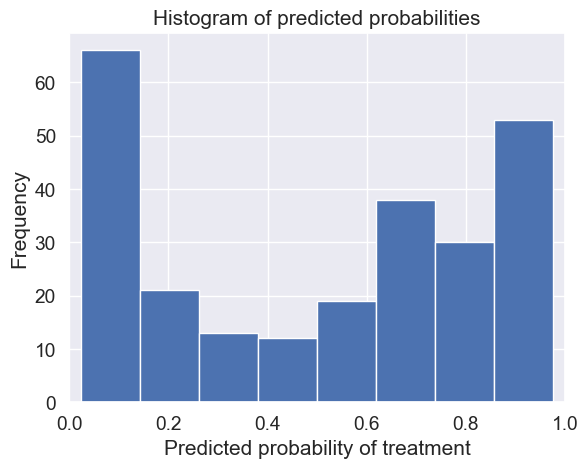

In [31]:
def logisticRegression():
    # Train a logistic regression model on the training set
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

    # Make class predictions for the testing set
    y_pred_class = logreg.predict(X_test)

    print('----------- Logistic Regression -------------')

    # Ensure evalClassModel() works correctly
    accuracy_score = evalClassModel(logreg, y_test, y_pred_class, plot=True)

    # Store accuracy score in dictionary
    methodDictionary['Log. Regres.'] = accuracy_score * 100

logisticRegression()

------------ Random Forests ------------
Accuracy: 0.8055555555555556
Null accuracy:
 treatment
0    129
1    123
Name: count, dtype: int64
Percentage of ones: 0.4880952380952381
Percentage of zeros: 0.5119047619047619
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


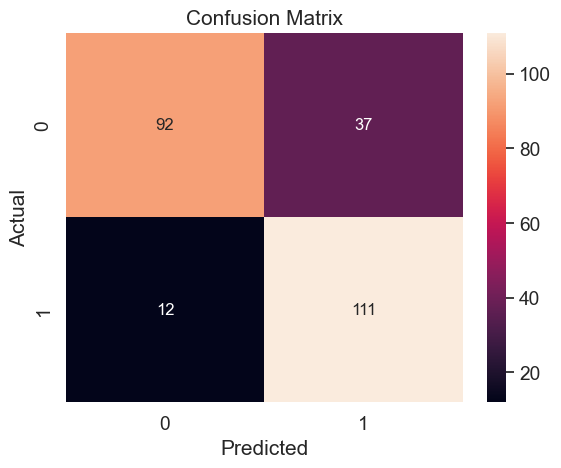

Classification Accuracy: 0.8055555555555556
Classification Error: 0.19444444444444442
False Positive Rate: 0.2868217054263566
Precision: 0.75
AUC Score: 0.8078086594819436
Cross-validated AUC: 0.8934280651104528
First 10 predicted responses:
 [1 0 0 0 0 1 0 0 1 1]
First 10 predicted probabilities of class members:
 [[0.19487059 0.80512941]
 [0.95968649 0.04031351]
 [0.96228281 0.03771719]
 [0.87387275 0.12612725]
 [0.55282459 0.44717541]
 [0.1218123  0.8781877 ]
 [0.80640167 0.19359833]
 [0.54653213 0.45346787]
 [0.22623089 0.77376911]
 [0.1837498  0.8162502 ]]
First 10 predicted probabilities:
 [[0.80512941]
 [0.04031351]
 [0.03771719]
 [0.12612725]
 [0.44717541]
 [0.8781877 ]
 [0.19359833]
 [0.45346787]
 [0.77376911]
 [0.8162502 ]]
[[ 92  37]
 [ 12 111]]


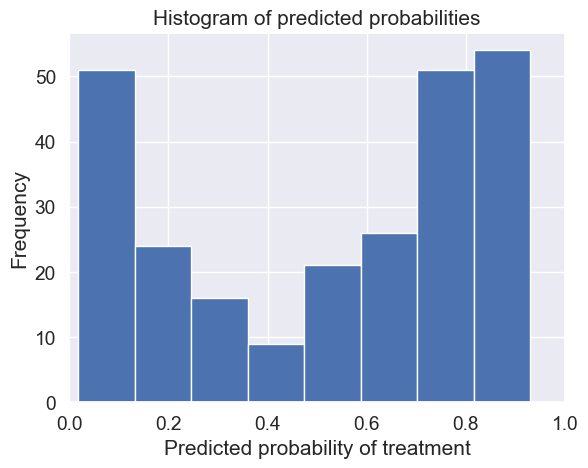

In [32]:
def randomForest():
    # Calculating the best parameters
    forest = RandomForestClassifier(n_estimators = 20)

    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

    # Building and fitting my_forest
    forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 1)
    my_forest = forest.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = my_forest.predict(X_test)

    print('------------ Random Forests ------------')

    accuracy_score = evalClassModel(my_forest, y_test, y_pred_class, True)

    #Data for final graph
    methodDictionary['R. Forest'] = accuracy_score * 100
randomForest()

Fitting 3 folds for each of 192 candidates, totalling 576 fits
------------ Neural Network ------------
Accuracy: 0.8015873015873016
Null accuracy:
 treatment
0    129
1    123
Name: count, dtype: int64
Percentage of ones: 0.4880952380952381
Percentage of zeros: 0.5119047619047619
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


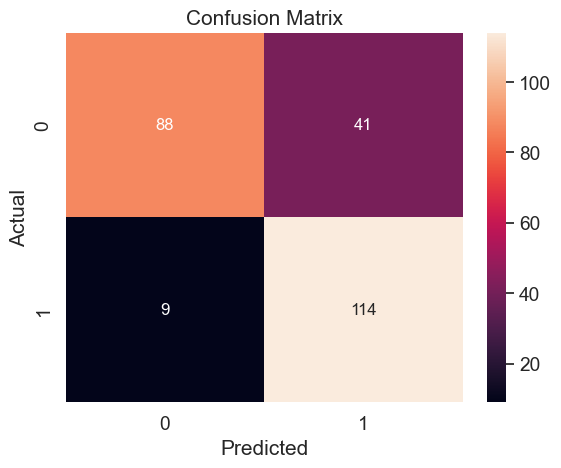

Classification Accuracy: 0.8015873015873016
Classification Error: 0.19841269841269837
False Positive Rate: 0.3178294573643411
Precision: 0.7354838709677419
AUC Score: 0.8044999054641709


c:\Users\91824\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\91824\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\91824\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\91824\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Cross-validated AUC: 0.8920597362675655
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.11911634 0.88088366]
 [0.9948309  0.0051691 ]
 [0.99503801 0.00496199]
 [0.89119236 0.10880764]
 [0.39565155 0.60434845]
 [0.05801038 0.94198962]
 [0.84911534 0.15088466]
 [0.22116581 0.77883419]
 [0.32290456 0.67709544]
 [0.25720534 0.74279466]]
First 10 predicted probabilities:
 [[0.88088366]
 [0.0051691 ]
 [0.00496199]
 [0.10880764]
 [0.60434845]
 [0.94198962]
 [0.15088466]
 [0.77883419]
 [0.67709544]
 [0.74279466]]
[[ 88  41]
 [  9 114]]


c:\Users\91824\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


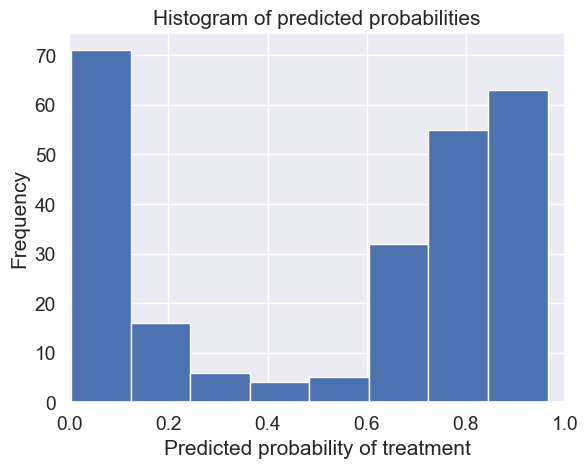

In [33]:
from sklearn.neural_network import MLPClassifier
def neuralNetwork():
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], # Experiment with different layer sizes
        'activation': ['relu', 'tanh'],  # Activation functions
        'alpha': [0.0001, 0.001, 0.01], # L2 regularization strength
        'learning_rate_init': [0.001, 0.01], # Initial learning rate
        'solver': ['adam', 'sgd'], # Optimization algorithm
        'max_iter': [200, 300] # Number of epochs
    }

    nn = MLPClassifier(random_state=1, max_iter=200) # Start with some reasonable defaults

    from sklearn.model_selection import GridSearchCV

    grid_search = GridSearchCV(nn, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)  # n_jobs uses all processors

    grid_search.fit(X_train, y_train)

    # Get the best model from the grid search
    best_nn = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred_class = best_nn.predict(X_test)

    print('------------ Neural Network ------------')

    accuracy_score_nn = evalClassModel(best_nn, y_test, y_pred_class, True) # Assuming evalClassModel is defined

    # Data for final graph
    methodDictionary['Neural Network'] = accuracy_score_nn * 100

neuralNetwork()

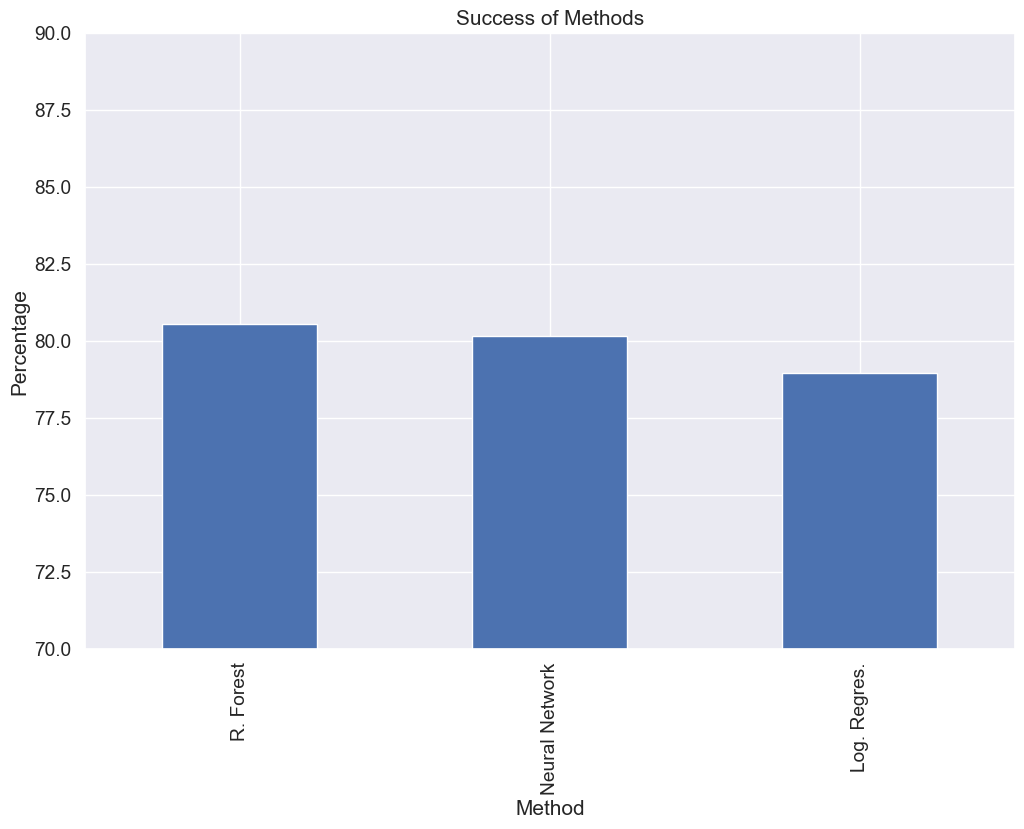

In [34]:
def plotSuccess():
    success = pd.Series(methodDictionary)
    success = success.sort_values(ascending=False)

    plt.figure(figsize=(12, 8))

    # Create bar plot
    ax = success.plot(kind='bar')
    plt.ylim([70.0, 90.0])  # Set y-axis limits
    plt.xlabel('Method')
    plt.ylabel('Percentage')
    plt.title('Success of Methods')

    plt.show()

plotSuccess()

In [35]:
methodDictionary

{'Log. Regres.': 78.96825396825396,
 'R. Forest': 80.55555555555556,
 'Neural Network': 80.15873015873017}

------------ Random Forests ------------
Accuracy: 0.8055555555555556
Null accuracy:
 treatment
0    129
1    123
Name: count, dtype: int64
Percentage of ones: 0.4880952380952381
Percentage of zeros: 0.5119047619047619
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


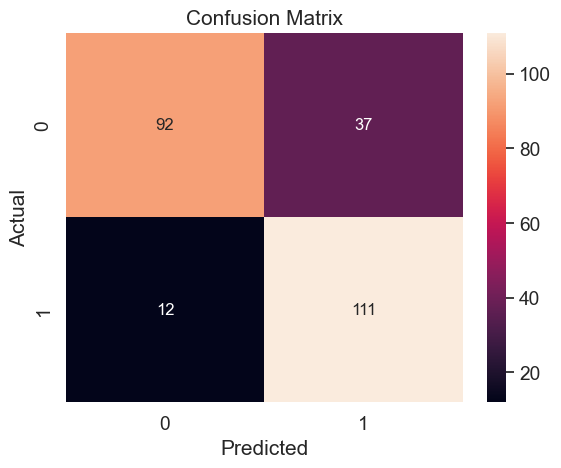

Classification Accuracy: 0.8055555555555556
Classification Error: 0.19444444444444442
False Positive Rate: 0.2868217054263566
Precision: 0.75
AUC Score: 0.8078086594819436
Cross-validated AUC: 0.8934280651104528
First 10 predicted responses:
 [1 0 0 0 0 1 0 0 1 1]
First 10 predicted probabilities of class members:
 [[0.19487059 0.80512941]
 [0.95968649 0.04031351]
 [0.96228281 0.03771719]
 [0.87387275 0.12612725]
 [0.55282459 0.44717541]
 [0.1218123  0.8781877 ]
 [0.80640167 0.19359833]
 [0.54653213 0.45346787]
 [0.22623089 0.77376911]
 [0.1837498  0.8162502 ]]
First 10 predicted probabilities:
 [[0.80512941]
 [0.04031351]
 [0.03771719]
 [0.12612725]
 [0.44717541]
 [0.8781877 ]
 [0.19359833]
 [0.45346787]
 [0.77376911]
 [0.8162502 ]]
[[ 92  37]
 [ 12 111]]


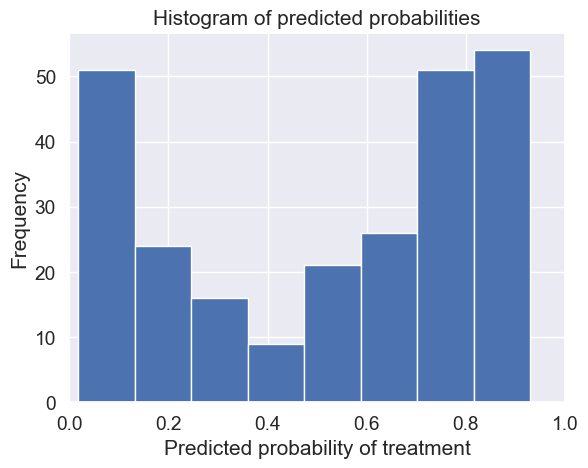

In [36]:
def randomForest():
    # Calculating the best parameters
    forest = RandomForestClassifier(n_estimators = 20)

    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

    # Building and fitting my_forest
    forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 1)
    my_forest = forest.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = my_forest.predict(X_test)

    print('------------ Random Forests ------------')

    accuracy_score = evalClassModel(my_forest, y_test, y_pred_class, True)

    #Data for final graph
    methodDictionary['R. Forest'] = accuracy_score * 100
    return my_forest

best_model = randomForest()

c:\Users\91824\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


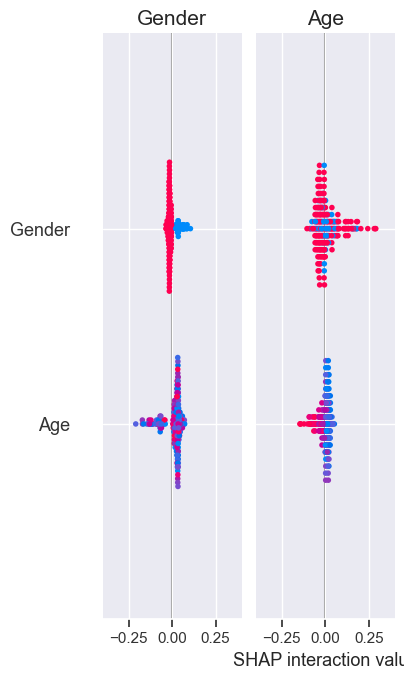

In [39]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test)

In [37]:
# saving the model

import joblib

model_filename = "best_model.joblib"  # Choose a filename
joblib.dump(best_model, model_filename)  # Save the model

['best_model.joblib']

In [38]:
best_model.predict([X_test.iloc[0].values]), y_test.iloc[0]

c:\Users\91824\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


(array([1]), 0)

In [ ]:
X_test.columns

Index(['Age', 'Gender', 'family_history', 'benefits', 'care_options',
       'anonymity', 'leave', 'work_interfere'],
      dtype='object')

In [ ]:
y_test

,treatment
5,0
494,0
52,0
984,0
186,0
...,...
1103,0
31,0
408,0
64,0
